In [180]:
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import root_mean_squared_error

In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [182]:
ticker = "AAPL"
df= yf.download(ticker, start = "2020-1-1")
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620850,72.681296,71.373226,71.627100,135480400
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146935,72.753816,71.926907,72.497522,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200
...,...,...,...,...,...
2025-06-02,201.699997,202.130005,200.119995,200.279999,35423300
2025-06-03,203.270004,203.770004,200.960007,201.350006,46381600


<Axes: xlabel='Date'>

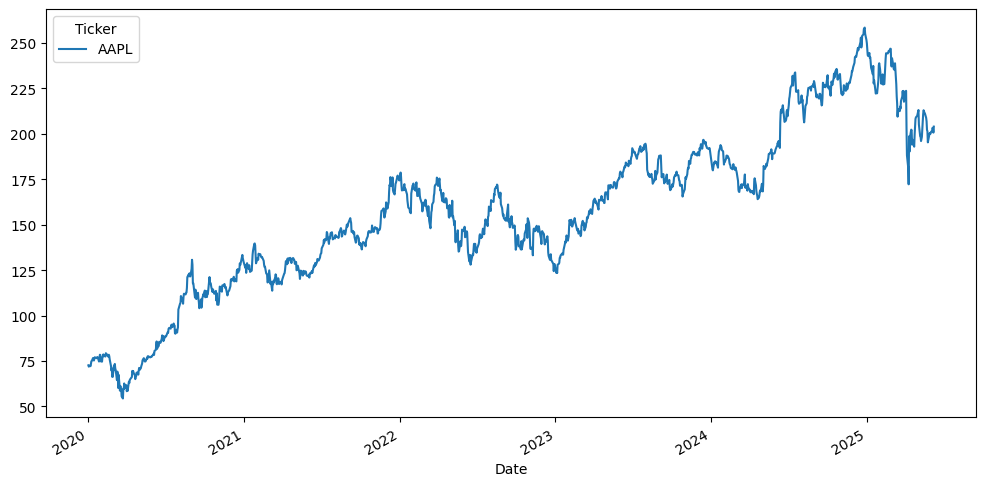

In [183]:
df.Close.plot(figsize= (12,6))

After visualizing the data, we are going to add a standard scaler to help with training the data. Also going to split into train/test splits.

In [184]:

scaler = StandardScaler()
df["Close"] = scaler.fit_transform(df["Close"])


In [185]:
seq_length= 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])
data = np.array(data)
train_size = int(.8 *len(data))
X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [186]:
class Prediction(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(Prediction, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first= True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device= device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim,device= device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [187]:
model = Prediction(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1).to(device)

In [188]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= .01)


Shows how the model will learn, MSE is good 
for regression tasks and show how off your predictions are and the optimizer is using adam to optimize the model

In [189]:
num_epochs = 200
for i in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    if i % 25 == 0:
        print(i,loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 0.5893063545227051
25 0.00938545074313879
50 0.005986044183373451
75 0.005226724315434694
100 0.004828556906431913
125 0.0045045227743685246
150 0.004201171919703484
175 0.003919750917702913


In [190]:
model.eval()
y_test_pred = model(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())

In [197]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:, 0])

2.6944377422332764

In [198]:
train_rmse

2.6944377422332764

In [199]:
test_rmse

7.4132304191589355

SyntaxError: invalid syntax (187083285.py, line 1)